<a href="https://colab.research.google.com/github/Jaesu26/dacon-basic/blob/main/2022-12-01-%EC%B6%95%EA%B5%AC%EC%84%A0%EC%88%98%EC%9C%A0%EB%A7%9D%EC%97%AC%EB%B6%80%EB%B6%84%EB%A5%98-private-4%EC%9C%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 축구선수의 유망 여부 예측 AI 경진대회

In [1]:
!nvidia-smi

Thu Dec  1 10:22:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    34W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pytorch-lightning==1.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


`-` 런타임 재시작

## 데이터 불러오기

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import random
import easydict
import os
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score

from typing import Dict, List, Optional, Tuple, Union
from numpy.typing import NDArray

from tqdm.auto import tqdm
from glob import glob

warnings.filterwarnings('ignore') 

In [4]:
from google.colab import drive

drive.mount('/content/drive')  # 구글코랩과 구글드라이브 연결

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
%cd /content/drive/MyDrive/Colab Notebooks/축구선수-유망여부-분류

/content/drive/MyDrive/Colab Notebooks/축구선수-유망여부-분류


- 데이터 불러오기

In [32]:
df = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

df = df.drop('ID', axis=1)
test = test.drop('ID', axis=1)

- 하이퍼파라미터 

In [7]:
args = easydict.EasyDict({
    'weight_path':'./weights',
    'num_classes':1,
    'num_folds':5,
    'num_epochs':50,
    'bs':64,    # batch size
    'lr':1e-3,  # learning rate
    'label_smoothing':0.05,
    'gradient_clip_val':1.0,
    'mc_iteration':30,
    'seed':22
})

- 가중치 저장폴더

In [8]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

In [9]:
create_folder(args.weight_path)

## 시각화

In [10]:
sns.set_theme(style='white')

In [38]:
pd.set_option('display.max_rows', None)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,3019.0,19.632329,1.235638,16.0000,19.00000,20.0000,21.0000,21.0000
Height,3019.0,180.892348,6.800187,160.0000,176.00000,180.0000,185.5000,204.0000
Weight,3019.0,73.081153,6.539758,49.0000,69.00000,73.0000,77.0000,99.0000
PaceTotal,3019.0,5.760521,1.298024,0.7246,4.92750,5.7971,6.6667,9.7101
ShootingTotal,3019.0,4.292595,1.624982,0.5263,3.09210,4.6053,5.5263,9.8684
PassingTotal,3019.0,4.080918,1.301538,0.0000,3.23530,4.1176,5.0000,8.2353
DribblingTotal,3019.0,4.708363,1.366596,0.0000,3.93940,4.8485,5.6061,9.3939
DefendingTotal,3019.0,3.816096,2.029423,0.0000,1.84210,4.2105,5.5263,8.6842
PhysicalityTotal,3019.0,4.549276,1.414989,0.0000,3.60660,4.5902,5.5738,9.3443
Crossing,3019.0,4.371896,1.790045,0.1136,3.29550,4.7727,5.6818,8.5227


`-` 컬럼별로 문제가 될만한 이상치는 없다

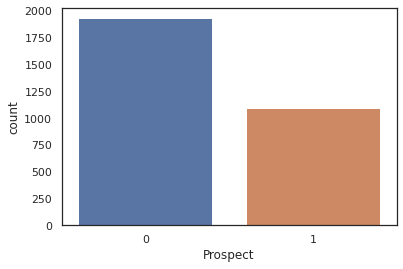

In [11]:
sns.countplot(df['Prospect'])

`-` 라벨 불균형이 존재한다

`-` 평가산식은 `macro f1`으로 긍정 라벨과 부정 라벨의 중요도가 동일하다

`-` 오버샘플링을 통해 샘플의 수를 맞춰주겠다

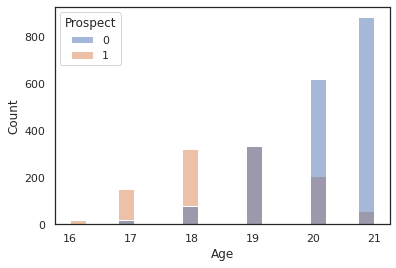

In [12]:
sns.histplot(data=df, x='Age', hue='Prospect')

`-` 유망 여부를 분류하는데 가장 중요한 변수

## 모델 학습 준비

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _WeightedLoss
from torch.optim import Optimizer

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

In [14]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True  
    torch.backends.cudnn.benchmark = False  
    torch.backends.cudnn.enabled = False

- 나이를 기준으로 변수 추가

`-` 18살 이하이면 '0', 19살이면 '1', 20살 이상이면 '2'로 인코딩하겠다

In [15]:
df['AgeGroup'] = df['Age'].apply(lambda x: '0' if x <= 18 else ('1' if x == 19 else '2'))
test['AgeGroup'] = test['Age'].apply(lambda x: '0' if x <= 18 else ('1' if x == 19 else '2'))

- 수치형 변수 스케일링

`-` 컬럼별로 문제가 될만한 이상치는 없다

In [16]:
minmax_scaler = MinMaxScaler()
quality_columns = df.columns[(df.dtypes == np.int) | (df.dtypes == np.float)].drop('Prospect')
for col in quality_columns:
    df[col] = minmax_scaler.fit_transform(df[[col]])
    test[col] = minmax_scaler.transform(test[[col]])

- 범주형 변수 원핫인코딩

In [17]:
onehot_encoder = OneHotEncoder(sparse=False)
quantity_columns = df.columns[df.dtypes == 'object']
for col in quantity_columns:
    df = pd.concat([df, pd.DataFrame(onehot_encoder.fit_transform(df[[col]]), columns=onehot_encoder.categories_[0])], axis=1)
    test = pd.concat([test, pd.DataFrame(onehot_encoder.transform(test[[col]]), columns=onehot_encoder.categories_[0])], axis=1)

df = df.drop(quantity_columns, axis=1)
test = test.drop(quantity_columns, axis=1)

In [18]:
df.shape, test.shape

((3019, 87), (1626, 86))

- 데이터 셋과 데이터 로더

In [19]:
class CustomDataset(Dataset):
    def __init__(
        self, 
        X: NDArray[np.float_],
        y: Optional[NDArray[np.int_]] = None
    ) -> None:
        self.X = X
        self.y = y
    
    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, Tensor, int], Tuple[Tensor, Tensor]]:
        X = torch.FloatTensor(self.X[idx])
        if self.y is not None:
            y = torch.FloatTensor(self.y[idx])  # y shape: (B, 1)
            return X, y
        return X

    def __len__(self) -> int:
        return self.X.shape[0]

- 모델 선언

In [20]:
def get_block(in_features, out_features, drop_prob=0.3):
    return nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.Mish(),
            nn.Dropout(p=drop_prob)
        )
        

def init_weights(model):
    classname = model.__class__.__name__
    if classname.find('Linear') != -1:
        y = model.in_features
        model.weight.data.normal_(0.0, np.sqrt(1 / y))
        model.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)

In [21]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.in_features_list = [86, 128, 256, 128]
        self.out_features_list = [128, 256, 128, 32]
        self.net = nn.Sequential(
            *[get_block(in_features, out_features) 
            for in_features, out_features in zip(self.in_features_list, self.out_features_list)]
        )
        self.classifier = nn.Linear(self.out_features_list[-1], num_classes)  

    def forward(self, x):
        x = self.net(x)
        x = self.classifier(x)
        return x 

In [22]:
class LightningNet(pl.LightningModule):
    def __init__(self, **kwargs):
        super(LightningNet, self).__init__()
        self.save_hyperparameters(logger=False)  
        self.model = Net(self.hparams.num_classes).apply(init_weights)
        self.label_smoothing = self.hparams.label_smoothing
        self.dropout = nn.Dropout(p=0.5)               # monte carlo dropout
        self.mc_iteration = self.hparams.mc_iteration  # monte carlo dropout

    def forward(self, x):
        x = self.model(x)
        return x

    def step(self, batch, batch_idx):
        x, y = batch
        smooth_y = y * (1.0 - self.hparams.label_smoothing) + 0.5*self.hparams.label_smoothing  # label smoothing
        y_hat = self(x)
        loss = F.binary_cross_entropy_with_logits(y_hat, smooth_y)
        return {'loss':loss, 'y':y, 'y_hat':y_hat}

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        print(f'Epoch {self.current_epoch} | Train Loss: {avg_loss:.4f}', end='  ')

    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx)

    def validation_epoch_end(self, outputs):
        y = torch.cat([x['y'] for x in outputs]).detach().cpu().numpy()
        y_hat = torch.cat([F.sigmoid(x['y_hat']) for x in outputs]).detach().cpu().numpy()
        y_hat = np.where(y_hat > 0.5, 1, 0)

        acc = accuracy_score(y, y_hat)
        f1 = f1_score(y, y_hat, average='macro')
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()

        self.log_dict({'val_f1':f1}, logger=False)
        print(f'Val Loss: {avg_loss:.4f}  Val Acc: {acc:.4f}  Val F1: {f1:.4f}')
 
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch

        # enable Monte Carlo Dropout
        self.dropout.train()

        # take average of `self.mc_iteration` iterations
        pred = [self.dropout(self.model(x)) for _ in range(self.mc_iteration)]
        pred = F.sigmoid(torch.stack(pred).mean(dim=0)).cpu().numpy()  
        return pred

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=args.lr)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
        return [optimizer], [scheduler]

In [23]:
class DataModule(pl.LightningDataModule):
    def __init__(self, X, y, X_predict, **kwargs):
        super(DataModule, self).__init__()
        self.save_hyperparameters(logger=False)  
        self.X = X
        self.y = y
        self.X_predict = X_predict

    def setup(self, stage):
        if stage == 'fit':
            skfold = StratifiedKFold(n_splits=self.hparams.num_folds, shuffle=True, random_state=self.hparams.seed)
            idx_splits = [[train_idx, val_idx] for train_idx, val_idx in skfold.split(self.X, self.y)]
            train_idx, val_idx = idx_splits[self.hparams.current_fold]
            
            X_train, y_train, X_val, y_val = self.X[train_idx], self.y[train_idx], self.X[val_idx], self.y[val_idx]
            X_train, y_train = SMOTE(random_state=self.hparams.seed).fit_resample(X_train, y_train)  # over-sampling  
            y_train, y_val = y_train.reshape(-1, 1), y_val.reshape(-1, 1)

            self.train_dataset = CustomDataset(X_train, y_train) 
            self.val_dataset = CustomDataset(X_val, y_val) 
        elif stage == 'predict':
            self.predict_dataset = CustomDataset(self.X_predict)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.hparams.bs, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.hparams.bs, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.predict_dataset, batch_size=self.hparams.bs, shuffle=False)

## 모델 교차검증 및 예측

- 모델 k-fold 교차검증

In [24]:
y = df.pop('Prospect').values
X = df.to_numpy()
X_predict = test.to_numpy()

In [25]:
preds = np.zeros(shape=(X_predict.shape[0], args.num_classes))
for fold in tqdm(range(args.num_folds)):
    print(f'\n[{fold + 1} / {args.num_folds}] Fold Training......', end='\n'*2)
    seed_everything(args.seed)
    model = LightningNet(**args)
    datamodule = DataModule(X, y, X_predict, current_fold=fold, **args)

    checkpoint_callback = ModelCheckpoint(dirpath=args.weight_path,
                                          filename=str(fold+1) + 'fold-{epoch}-{val_f1:.2f}',
                                          monitor='val_f1',
                                          mode='max',
                                          save_weights_only=True)

    early_stopping = EarlyStopping(monitor='val_f1', 
                                   patience=10,
                                   verbose=False,
                                   mode='max')

    trainer = pl.Trainer(accelerator='gpu', 
                         devices=1, 
                         gradient_clip_val=args.gradient_clip_val, 
                         logger=False,
                         enable_progress_bar=False, 
                         max_epochs=args.num_epochs,
                         callbacks=[checkpoint_callback, early_stopping])

    trainer.fit(model, datamodule=datamodule)
    pred = trainer.predict(model, datamodule=datamodule, ckpt_path=checkpoint_callback.best_model_path)
    preds += (np.concatenate(pred) / args.num_folds)

  0%|          | 0/5 [00:00<?, ?it/s]


[1 / 5] Fold Training......



INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | model   | Net     | 82.3 K
1 | dropout | Dropout | 0     
------------------------------------
82.3 K    Trainable params
0         Non-trainable params
82.3 K    Total params
0.329     Total estimated model params size (MB)


Val Loss: 0.6920  Val Acc: 0.4609  Val F1: 0.4318
Val Loss: 0.5041  Val Acc: 0.7848  Val F1: 0.7589
Epoch 0 | Train Loss: 0.5816  Val Loss: 0.5132  Val Acc: 0.7798  Val F1: 0.7655
Epoch 1 | Train Loss: 0.5462  Val Loss: 0.5019  Val Acc: 0.7881  Val F1: 0.7729
Epoch 2 | Train Loss: 0.5320  Val Loss: 0.4956  Val Acc: 0.7947  Val F1: 0.7784
Epoch 3 | Train Loss: 0.5160  Val Loss: 0.4893  Val Acc: 0.7914  Val F1: 0.7761
Epoch 4 | Train Loss: 0.5175  Val Loss: 0.5079  Val Acc: 0.7781  Val F1: 0.7659
Epoch 5 | Train Loss: 0.5107  Val Loss: 0.4958  Val Acc: 0.7848  Val F1: 0.7685
Epoch 6 | Train Loss: 0.5025  Val Loss: 0.5070  Val Acc: 0.7765  Val F1: 0.7628
Epoch 7 | Train Loss: 0.4935  Val Loss: 0.5108  Val Acc: 0.7765  Val F1: 0.7655
Epoch 8 | Train Loss: 0.4921  Val Loss: 0.5347  Val Acc: 0.7732  Val F1: 0.7646
Epoch 9 | Train Loss: 0.4885  Val Loss: 0.5159  Val Acc: 0.7765  Val F1: 0.7665
Epoch 10 | Train Loss: 0.4909  Val Loss: 0.4904  Val Acc: 0.7864  Val F1: 0.7709
Epoch 11 | Train Lo

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/축구선수-유망여부-분류/weights/1fold-epoch=3-val_f1=0.78.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/Colab Notebooks/축구선수-유망여부-분류/weights/1fold-epoch=3-val_f1=0.78.ckpt


Val Loss: 0.4981  Val Acc: 0.7831  Val F1: 0.7702
Epoch 13 | Train Loss: 0.4796  

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | model   | Net     | 82.3 K
1 | dropout | Dropout | 0     
------------------------------------
82.3 K    Trainable params
0         Non-trainable params
82.3 K    Total params
0.329     Total estimated model params size (MB)



[2 / 5] Fold Training......

Val Loss: 0.6937  Val Acc: 0.4531  Val F1: 0.4394
Val Loss: 0.5355  Val Acc: 0.7781  Val F1: 0.7614
Epoch 0 | Train Loss: 0.5612  Val Loss: 0.5656  Val Acc: 0.7748  Val F1: 0.7621
Epoch 1 | Train Loss: 0.5205  Val Loss: 0.5330  Val Acc: 0.7798  Val F1: 0.7647
Epoch 2 | Train Loss: 0.5059  Val Loss: 0.5582  Val Acc: 0.7765  Val F1: 0.7640
Epoch 3 | Train Loss: 0.4962  Val Loss: 0.5387  Val Acc: 0.7765  Val F1: 0.7603
Epoch 4 | Train Loss: 0.4975  Val Loss: 0.5564  Val Acc: 0.7715  Val F1: 0.7589
Epoch 5 | Train Loss: 0.4943  Val Loss: 0.5818  Val Acc: 0.7616  Val F1: 0.7514
Epoch 6 | Train Loss: 0.4890  Val Loss: 0.5463  Val Acc: 0.7715  Val F1: 0.7538
Epoch 7 | Train Loss: 0.4858  Val Loss: 0.5607  Val Acc: 0.7616  Val F1: 0.7476
Epoch 8 | Train Loss: 0.4761  Val Loss: 0.5816  Val Acc: 0.7517  Val F1: 0.7431
Epoch 9 | Train Loss: 0.4710  Val Loss: 0.5549  Val Acc: 0.7765  Val F1: 0.7616
Epoch 10 | Train Loss: 0.4718  Val Loss: 0.5605  Val Acc: 0.7500  Val 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/축구선수-유망여부-분류/weights/2fold-epoch=2-val_f1=0.76.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/Colab Notebooks/축구선수-유망여부-분류/weights/2fold-epoch=2-val_f1=0.76.ckpt


Val Loss: 0.5531  Val Acc: 0.7666  Val F1: 0.7510
Epoch 12 | Train Loss: 0.4660  

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | model   | Net     | 82.3 K
1 | dropout | Dropout | 0     
------------------------------------
82.3 K    Trainable params
0         Non-trainable params
82.3 K    Total params
0.329     Total estimated model params size (MB)



[3 / 5] Fold Training......

Val Loss: 0.6938  Val Acc: 0.4375  Val F1: 0.4170
Val Loss: 0.5370  Val Acc: 0.7483  Val F1: 0.7299
Epoch 0 | Train Loss: 0.5712  Val Loss: 0.5393  Val Acc: 0.7500  Val F1: 0.7333
Epoch 1 | Train Loss: 0.5274  Val Loss: 0.5511  Val Acc: 0.7517  Val F1: 0.7367
Epoch 2 | Train Loss: 0.5158  Val Loss: 0.5358  Val Acc: 0.7483  Val F1: 0.7299
Epoch 3 | Train Loss: 0.5123  Val Loss: 0.5396  Val Acc: 0.7517  Val F1: 0.7371
Epoch 4 | Train Loss: 0.5120  Val Loss: 0.5488  Val Acc: 0.7533  Val F1: 0.7391
Epoch 5 | Train Loss: 0.5004  Val Loss: 0.5442  Val Acc: 0.7434  Val F1: 0.7290
Epoch 6 | Train Loss: 0.4932  Val Loss: 0.5264  Val Acc: 0.7483  Val F1: 0.7323
Epoch 7 | Train Loss: 0.4948  Val Loss: 0.5351  Val Acc: 0.7368  Val F1: 0.7220
Epoch 8 | Train Loss: 0.4921  Val Loss: 0.5561  Val Acc: 0.7235  Val F1: 0.7131
Epoch 9 | Train Loss: 0.4842  Val Loss: 0.5368  Val Acc: 0.7434  Val F1: 0.7319
Epoch 10 | Train Loss: 0.4835  Val Loss: 0.5352  Val Acc: 0.7401  Val 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/축구선수-유망여부-분류/weights/3fold-epoch=12-val_f1=0.74.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/Colab Notebooks/축구선수-유망여부-분류/weights/3fold-epoch=12-val_f1=0.74.ckpt


Val Loss: 0.5402  Val Acc: 0.7318  Val F1: 0.7188
Epoch 22 | Train Loss: 0.4644  

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | model   | Net     | 82.3 K
1 | dropout | Dropout | 0     
------------------------------------
82.3 K    Trainable params
0         Non-trainable params
82.3 K    Total params
0.329     Total estimated model params size (MB)



[4 / 5] Fold Training......

Val Loss: 0.6953  Val Acc: 0.4062  Val F1: 0.3846
Val Loss: 0.4590  Val Acc: 0.8046  Val F1: 0.7907
Epoch 0 | Train Loss: 0.5892  Val Loss: 0.4749  Val Acc: 0.8013  Val F1: 0.7867
Epoch 1 | Train Loss: 0.5384  Val Loss: 0.4648  Val Acc: 0.8030  Val F1: 0.7875
Epoch 2 | Train Loss: 0.5264  Val Loss: 0.4931  Val Acc: 0.7964  Val F1: 0.7863
Epoch 3 | Train Loss: 0.5118  Val Loss: 0.4828  Val Acc: 0.8013  Val F1: 0.7900
Epoch 4 | Train Loss: 0.5079  Val Loss: 0.4871  Val Acc: 0.7930  Val F1: 0.7832
Epoch 5 | Train Loss: 0.5195  Val Loss: 0.4724  Val Acc: 0.7980  Val F1: 0.7847
Epoch 6 | Train Loss: 0.5019  Val Loss: 0.4838  Val Acc: 0.8030  Val F1: 0.7916
Epoch 7 | Train Loss: 0.5132  Val Loss: 0.4715  Val Acc: 0.8013  Val F1: 0.7879
Epoch 8 | Train Loss: 0.5014  Val Loss: 0.4744  Val Acc: 0.7980  Val F1: 0.7844
Epoch 9 | Train Loss: 0.4971  Val Loss: 0.4804  Val Acc: 0.7930  Val F1: 0.7822
Epoch 10 | Train Loss: 0.4851  Val Loss: 0.4785  Val Acc: 0.8013  Val 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/축구선수-유망여부-분류/weights/4fold-epoch=7-val_f1=0.79.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/Colab Notebooks/축구선수-유망여부-분류/weights/4fold-epoch=7-val_f1=0.79.ckpt


Val Loss: 0.4999  Val Acc: 0.7666  Val F1: 0.7584
Epoch 17 | Train Loss: 0.4706  

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params
------------------------------------
0 | model   | Net     | 82.3 K
1 | dropout | Dropout | 0     
------------------------------------
82.3 K    Trainable params
0         Non-trainable params
82.3 K    Total params
0.329     Total estimated model params size (MB)



[5 / 5] Fold Training......

Val Loss: 0.6922  Val Acc: 0.4766  Val F1: 0.4591
Val Loss: 0.4977  Val Acc: 0.7761  Val F1: 0.7568
Epoch 0 | Train Loss: 0.5780  Val Loss: 0.5033  Val Acc: 0.7761  Val F1: 0.7614
Epoch 1 | Train Loss: 0.5318  Val Loss: 0.4964  Val Acc: 0.7811  Val F1: 0.7656
Epoch 2 | Train Loss: 0.5256  Val Loss: 0.4932  Val Acc: 0.7778  Val F1: 0.7616
Epoch 3 | Train Loss: 0.5152  Val Loss: 0.4998  Val Acc: 0.7728  Val F1: 0.7587
Epoch 4 | Train Loss: 0.5164  Val Loss: 0.5262  Val Acc: 0.7711  Val F1: 0.7609
Epoch 5 | Train Loss: 0.5062  Val Loss: 0.5038  Val Acc: 0.7811  Val F1: 0.7684
Epoch 6 | Train Loss: 0.4983  Val Loss: 0.5236  Val Acc: 0.7479  Val F1: 0.7400
Epoch 7 | Train Loss: 0.4946  Val Loss: 0.4993  Val Acc: 0.7745  Val F1: 0.7610
Epoch 8 | Train Loss: 0.4986  Val Loss: 0.5079  Val Acc: 0.7629  Val F1: 0.7505
Epoch 9 | Train Loss: 0.4941  Val Loss: 0.5128  Val Acc: 0.7562  Val F1: 0.7475
Epoch 10 | Train Loss: 0.4898  Val Loss: 0.5138  Val Acc: 0.7579  Val 

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Colab Notebooks/축구선수-유망여부-분류/weights/5fold-epoch=6-val_f1=0.77.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/MyDrive/Colab Notebooks/축구선수-유망여부-분류/weights/5fold-epoch=6-val_f1=0.77.ckpt


Val Loss: 0.5246  Val Acc: 0.7413  Val F1: 0.7350
Epoch 16 | Train Loss: 0.4677  

- test 예측

In [30]:
submission['Prospect'] = np.where(preds > 0.5, 1, 0)
submission.to_csv('./data/submission-6.csv', index=False)

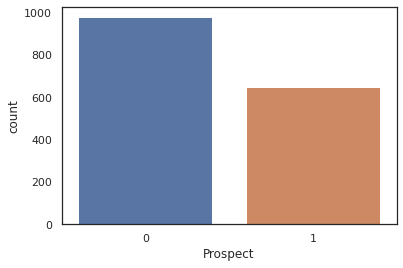

In [31]:
sns.countplot(submission['Prospect'])